# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
import torch
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
#print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
#print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size_All = states.shape
state_size = state_size_All[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
#print('The state for the first agent looks like:', states)

env_info = env.reset(train_mode=True)[brain_name]   
states = env_info.vector_observations
states = states[0]    
a = (torch.from_numpy(states)).float()
#print(a.size())


There are 1 agents. Each observes a state with length: 33


In [5]:
import numpy as np
import random
from collections import namedtuple, deque
import copy
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

BUFFER_SIZE = int(1e5)   # replay buffer size
GAMMA = 0.99             # discount factor
TAU   = 0.001            # for soft update of target parameters
LR_ACTOR  = 0.001        # learning rate of the actor 
LR_CRITIC = 0.001        # learning rate of the critic
WEIGHT_DECAY  = 0         # L2 weight decay
Clip_Grad     = 1        # Clip gradient using Norm
Copy_Local    = 1        # Copy local network parameters into target 
Noise_Sigma   = 0.01
Load_Models   = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device  = 'cpu'

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor_QNetwork(nn.Module):
    """Actor (Policy) Model. Gives actions for a state"""

    def __init__(self, state_size, action_size, fc1_units, fc2_units, seed, use_bn):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor_QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.use_bn = use_bn
        self.fc1 = nn.Linear(state_size, fc1_units)
        if self.use_bn:
            self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        if self.use_bn:
            self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)        
            
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)
        self.fc3.bias.data.fill_(0.1)    
    
    def add_parameter_noise(self, scalar_mult):
        self.fc1.weight.data += torch.randn_like(self.fc1.weight.data) * scalar_mult
        self.fc2.weight.data += torch.randn_like(self.fc2.weight.data) * scalar_mult
        self.fc3.weight.data += torch.randn_like(self.fc3.weight.data) * scalar_mult
            
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        """param state: Input state (Torch Variable : [n,state_dim] )
        return: Output action (Torch Variable: [n,action_dim] )"""
        if self.use_bn:
            x = self.bn1(self.fc1(state))
        else:            
            x = self.fc1(state)
            
        x = F.relu(x)
        x = self.fc2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)        
        return F.tanh(x)
        
class Critic_QNetwork(nn.Module):
    """Critic (Value) Model. Predicts Q-value for each (s,a) pair"""

    def __init__(self, state_size, action_size, fc1_units, fc2_units, seed, use_bn):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic_QNetwork, self).__init__()
        #self.seed = torch.manual_seed(seed)
        self.use_bn = use_bn
        self.fc1 = nn.Linear(state_size, fc1_units)
        if self.use_bn:
            self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        if self.use_bn:
            self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)
        self.fc3.bias.data.fill_(0.1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        """returns Value function Q(s,a) obtained from critic network
        param state: Input state (Torch Variable : [n,state_dim] )
        param action: Input Action (Torch Variable : [n,action_dim] )
        return: Value function : Q(S,a) (Torch Variable : [n,1] )"""
        
        if self.use_bn:
            x = self.bn1(self.fc1(state))
        else:            
            x = self.fc1(state)
            
        x = F.relu(x)
        xs = torch.cat((x, action), dim=1)        
        xs = self.fc2(xs)
        if self.use_bn:
            xs = self.bn2(xs)
        xs = F.relu(xs)
        xs = self.fc3(xs)
        
        return xs
              

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, fc1_node, fc2_node, seed, noise_type, desired_distance, 
                 scalarp, scalar_decay, normal_scalar):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
                
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        self.noise_type = noise_type

        # parameter noise
        self.distances = []
        self.desired_distance = desired_distance
        self.scalar = scalarp
        self.scalar_decay = scalar_decay

        # normal noise
        self.normal_scalar = normal_scalar
        

        # Actor Network (w/ Target Network)
        self.actor_local     = Actor_QNetwork(state_size, action_size, fc1_node, fc2_node, seed, True)
        self.actor_target    = Actor_QNetwork(state_size, action_size, fc1_node, fc2_node, seed, True)
        if(Copy_Local == 1):
            self.actor_target.load_state_dict(self.actor_local.state_dict())
        self.actor_local.to(device)
        self.actor_target.to(device)        
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        self.actor_noised = Actor_QNetwork(state_size, action_size, fc1_node, fc2_node, seed, True).to(device)

        # Critic Network (w/ Target Network)
        """Double Q-Learning uses Q-network-1 (qnetwork_local) to select actions and Q-network-2 (qnetwork_target) to evaluate the selected actions."""
        self.critic_local  = Critic_QNetwork(state_size, action_size, fc1_node, fc2_node, seed, True)
        self.critic_target = Critic_QNetwork(state_size, action_size, fc1_node, fc2_node, seed, True)
        if(Copy_Local == 1):
            self.critic_target.load_state_dict(self.critic_local.state_dict())
        self.critic_local.to(device)
        self.critic_target.to(device)         
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, Noise_Sigma, seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, seed)
        

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory        
        self.memory.add(state, action, reward, next_state, done)
    
    def start_learn(self, BATCH_SIZE):
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample(BATCH_SIZE)
            self.learn(experiences, GAMMA)     
        
    
    def act(self, state, Exploration=True):
        """Returns actions for given state as per current policy."""                
        # converting state (numpy representation) to tensor and expnading the dimension by adding a new dimension at the start
        # State is a vector with shape (dim). So, Using .unsqueeze(0) makes it (1,dim)
        # Every time we convert numpy to tensor, we need to send the tensor to the device
        if(num_agents == 1):
            state = (torch.from_numpy(state)).float().unsqueeze(0).to(device) 
        else:
            state = (torch.from_numpy(state)).float().to(device)  
        self.actor_local.train(mode=False)
        self.actor_noised.train(mode=False)
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        
            if Exploration:
                if self.noise_type == "param":
                    # hard copy the actor_regular to actor_noised
                    self.actor_noised.load_state_dict(self.actor_local.state_dict().copy())
                    # add noise to the copy
                    self.actor_noised.add_parameter_noise(self.scalar)
                    # get the next action values from the noised actor
                    action_noised = self.actor_noised(state).cpu().data.numpy()
                    # meassure the distance between the action values from the regular and 
                    # the noised actor to adjust the amount of noise that will be added next round
                    distance = np.sqrt(np.mean(np.square(action-action_noised)))
                    # for stats and print only
                    self.distances.append(distance)
                    # adjust the amount of noise given to the actor_noised
                    if distance > self.desired_distance:
                        self.scalar *= self.scalar_decay
                    if distance < self.desired_distance:
                        self.scalar /= self.scalar_decay
                    # set the noised action as action
                    action = action_noised

                elif self.noise_type == "ou":
                    action += self.noise.sample()
                elif self.noise_type == "Normal":
                    action += np.random.randn(self.action_size) * self.normal_scalar
        
        self.actor_local.train(mode=True)    
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states      = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions     = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards     = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones       = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        """ Pseudocode
        Sample an action using actor's policy and collect the new state and reward r
        Train the critic using the TD error: w←w+αw(r+γQw(s′,a′)–Qw(s,a))∇wQw(s,a). 
        Train the actor using policy gradient: θ←θ+αθQw(s,a)∇θlogπθ(a|s).
        """

        # ---------------------------- update critic ---------------------------- #
        #self.actor_target.train(mode=False)
        #self.critic_target.train(mode=False)
        #self.critic_local.train(mode=False)
        # Use Actor target network to get action : Output_size: [n,action_dim] 
        actions_next = self.actor_target(next_states)
        # Use Critic target network to get Q-value for a state-action pair: Output_size: [n,1]
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets_next = Q_targets_next.detach()
        
       
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
                    
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        #self.critic_local.train(mode=True)
        self.critic_optimizer.zero_grad()        
        critic_loss.backward()
        if(Clip_Grad == 1):
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        # Minimize the loss  
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()        
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)          

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_((1.0-tau)*target_param.data + tau*local_param.data)

    
    def save_models(self):
        self.actor_name  = 'Actor_Local_CB_' + self.noise_type + '.pth'
        self.critic_name = 'Critic_Local_CB_' + self.noise_type + '.pth'
        torch.save(self.actor_local.state_dict(),  self.actor_name)
        torch.save(self.critic_local.state_dict(), self.critic_name)
                
    def load_models(self):
        self.actor_name  = 'Actor_Local_' + self.noise_type + '.pth'
        self.critic_name = 'Critic_Local_' + self.noise_type + '.pth'
        
        self.actor_local.load_state_dict(torch.load(self.actor_name))
        self.critic_local.load_state_dict(torch.load(self.critic_name))
        self.actor_target.load_state_dict(torch.load(self.actor_name))
        self.critic_target.load_state_dict(torch.load(self.critic_name))
        print('Models loaded succesfully')
     
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self,batch_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=batch_size)
        return experiences       
  
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [17]:
Random_Seed = 5
hidden_layer_1 = 300
hidden_layer_2 = 400
Normal_noise = "Normal"
OU_noise     = "ou"
Param_noise  = "param"
curr_noise   = Normal_noise
desired_distance_pass = .5
scaler_pass           = .05
scalar_decay_pass     = .99
normal_scalar_pass    = .25
Load_Models   = 0

def Check_Increasing(X):
    res = all(i < j for i, j in zip(X, X[1:]))
    return res

def Elbow_Index(X):
    res = -1
    for idx in range(0, len(X) - 1):
        if X[idx + 1] < X[idx]:
            res = idx
            break
    return res

   
agent = Agent(state_size, action_size, hidden_layer_1, hidden_layer_2, Random_Seed, curr_noise, desired_distance_pass, 
              scaler_pass, scalar_decay_pass, normal_scalar_pass)
if(Load_Models == 1):
    agent.load_models()

if(Clip_Grad == 1):
    print('Clipping gradient using Norm')
else:
    print('No gradient clipping')

if(Copy_Local == 1):
    print('Same local and target starting values')
else:
    print('Different local and target starting values')


Clipping gradient using Norm
Same local and target starting values


In [18]:
def dqn(start_episode, n_episodes,UPDATE_EVERY,Num_Updates,Start_Batch_Size=64, episode_for_BS=30):
    Explore = True
    Episode_Score = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)         # last 100 scores
    Curr_Batch_Size = Start_Batch_Size
    
    Average_Score = []
       
    for i_episode in range(start_episode, start_episode+n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        if(num_agents == 1):
            states = states[0]
            scores = 0
        else:
            scores = np.zeros(num_agents)
        
        
        step_num = 0       
        while True:
            actions     = agent.act(states,Explore)
            env_info    = env.step(actions)[brain_name]            # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state (for each agent)
            rewards     = env_info.rewards                         # get reward (for each agent)
            dones       = env_info.local_done                      # see if episode finished
            
            
            if(num_agents == 1):
                next_states = next_states[0]
                rewards     = rewards[0]
                dones       = dones[0]
            
            
            if(num_agents > 1):
                for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                    agent.step(state, action, reward, next_state, done) # send actions to the agent
            else:
                agent.step(states, actions, rewards, next_states, dones) # send actions to the agent
            
            states = next_states
            scores += rewards
            
            step_num += 1
            
            # Learn every UPDATE_EVERY time steps.
            if step_num%UPDATE_EVERY == 0:
                    for _ in range(Num_Updates):
                        agent.start_learn(Curr_Batch_Size)                    
                      
            
            if np.any(dones): 
                break
        
        if(num_agents > 1):
            mean_score = np.mean(scores)            
        else:
            mean_score = scores
        
        scores_window.append(mean_score)
        Episode_Score.append(mean_score)
        
                
        if(i_episode > 160):
            if i_episode % 10 == 0:
                if(len(Average_Score) > 6):
                    list_increasing = Check_Increasing(Average_Score)
                    if(list_increasing == False):
                        elbow_index = Elbow_Index(Average_Score)
                        Elements_ahead = len(Average_Score) - elbow_index - 1

                        if(Elements_ahead > 5):
                            last_value = Average_Score[len(Average_Score)-1]
                            if(last_value + 1 < Average_Score[elbow_index]):
                                Curr_Batch_Size = min(Curr_Batch_Size*2,1024)
                                print('\n')
                                print('\rBatch Size {}'.format(Curr_Batch_Size))
                                Average_Score = []                

        
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, mean_score), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            Average_Score.append(np.mean(scores_window))
            agent.save_models()
        if np.mean(scores_window)> 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            agent.save_models()
            print('Models saved successfully')
            break
    return Episode_Score

In [ ]:
All_Score = dqn(1,600,10,10)

Episode 10	Average Score: 0.75
Episode 20	Average Score: 1.39
Episode 30	Average Score: 2.06
Episode 40	Average Score: 2.52
Episode 50	Average Score: 3.58
Episode 60	Average Score: 4.87
Episode 70	Average Score: 6.25
Episode 80	Average Score: 7.91
Episode 90	Average Score: 9.55
Episode 100	Average Score: 11.59
Episode 110	Average Score: 15.01
Episode 120	Average Score: 17.99
Episode 130	Average Score: 21.01
Episode 140	Average Score: 23.96
Episode 150	Average Score: 25.73
Episode 160	Average Score: 27.19
Episode 170	Average Score: 28.36
Episode 180	Average Score: 29.15
Episode 190	Average Score: 29.35
Episode 200	Average Score: 28.64
Episode 210	Average Score: 27.43
Episode 220	Average Score: 26.81
Episode 230	Average Score: 25.65
Episode 240	Average Score: 24.34
Episode 250	Average Score: 23.89
Episode 259	Score: 22.70

Batch Size 128
Episode 260	Average Score: 23.45
Episode 270	Average Score: 23.31
Episode 280	Average Score: 22.24
Episode 290	Average Score: 21.45
Episode 300	Average 

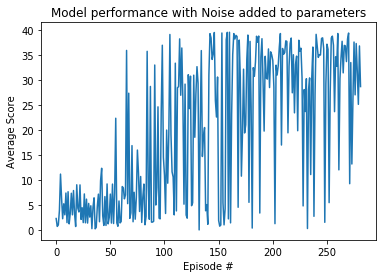

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(All_Score)), All_Score)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.title("Model performance with Noise added to parameters")
plt.show()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [19]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 